# corrected pipeline validation
after a first pass of the new dprime and metric calculation pipeline showed strong discrepancies in the values obtained
relative to the older approach. after a closer look (see 210222_pipeline_old_vs_new.ipynb) it was determined that there
were problems in the shuffling paradimg

These differencese were corrected (see the difference between consolidated_dprime v1 and v2).
Here I compare these values with those obtained with the old paradigm. If there are grose discrepancies
I will probalby favor the new method¸ since its logic is more adecuate: Shuffle all data, reduce dimension, calculate
pairwise dprimes

In [39]:
from configparser import ConfigParser
from pathlib import Path
from joblib import load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
from src.visualization.fancy_plots import unit_line
import seaborn as sns

In [40]:
plt.style.use('dark_background')
# modify figure color cycler back to the default one
color_cycler = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

params = {'legend.fontsize': 'medium',
          'axes.labelsize': 15,
          'axes.titlesize': 20,
          'axes.spines.top': False,
          'axes.spines.right': False,
          'axes.prop_cycle': color_cycler,
          'xtick.labelsize': 11,
          'ytick.labelsize': 11,
          'lines.markersize': 8,
          'figure.titlesize': 30,
          'figure.figsize': [6,6],
          'figure.autolayout':True,
          'svg.fonttype': 'none',
          'font.sans-serif': 'Arial'
          }

plt.rcParams.update(params)


In [ ]:
config = ConfigParser()
config.read_file(open(Path('../config/settings.ini')))

In [72]:
oldTripDF = load(Path("../data/DF_summary/dprime_absolute-None_montecarlo-1000_raster_fs-30_reliability-0.1_smoothing_window-0_transitions-['silence', 'continuous', 'similar', 'sharp']_zscore-True"))
oldPermDF = load(Path('../data/prm_summary_DF_v2/dprime_absolute-None_montecarlo-1000_raster_fs-30_reliability-0.1_smoothing_window-0_transitions-[0, 1, 2, 3, 4]_zscore-True'))
newDF = load(Path('../data/consolidated_summary_DF_v2/dprime_absolute-None_montecarlo-1000_raster_fs-30_reliability-0.1_smoothing_window-0_zscore-True'))

In [73]:
#Formats the old dataframes into the new naming systems and filters out old unused parameters and metadata
# create the id_probe pair

oldTripDF['stim_type'] = 'triplets'
oldPermDF['stim_type'] = 'permutations'

for odf in [oldTripDF, oldPermDF]:
    to_replace = {pname: pname.split('_')[-1] for pname in odf.probe.unique()}
    to_replace['dPCA'] = 'pdPCA'
    odf.replace(to_replace=to_replace, inplace=True)

    odf['id_probe'] = odf['cellid'].fillna(value=odf['siteid'])
    odf['id_probe'] = odf[['id_probe', 'probe']].agg('_'.join, axis=1)
    odf['mult_comp_corr'] = 'none'
    odf['mean_signif_type'] = 'mean'
    odf.rename(columns={'parameter':'metric',
                        'transition_pair': 'context_pair'}, inplace=True)


oldDF = pd.concat([oldTripDF, oldPermDF])

good_cols = ['id_probe', 'cellid', 'context_pair', 'probe', 'value', 'metric', 'mult_comp_corr',
             'mean_signif_type', 'stim_type', 'analysis', 'siteid', 'region']
ff_metric = oldDF.metric.isin(['significant_abs_sum', 'significant_abs_mass_center'])
oldDF = oldDF.loc[ff_metric, good_cols]

In [75]:
# formats the new dataframe
newDF['id_probe'] = newDF['cellid'].fillna(value=newDF['siteid'])
newDF['id_probe'] = newDF[['id_probe', 'probe']].agg('_'.join, axis=1)


In [76]:
print('old DF duplicates?: ', np.any(oldDF.duplicated()))
print('new Df duplicates?: ', np.any(newDF.duplicated()))

old DF duplicates?:  False
new Df duplicates?:  False


In [77]:
# concatenate the dataframes columsn, matching indices
all_indices = ['mult_comp_corr', 'mean_signif_type', 'stim_type', 'analysis', 'region',
               'id_probe','siteid', 'cellid', 'context_pair', 'probe', 'metric']

old_with_idx = oldDF.set_index(all_indices)
new_with_idx = newDF.set_index(all_indices)

old_with_idx.rename(columns={'value':'old_val'}, inplace=True)
new_with_idx.rename(columns={'value':'new_val'}, inplace=True)

Full = pd.concat([old_with_idx, new_with_idx], axis=1)

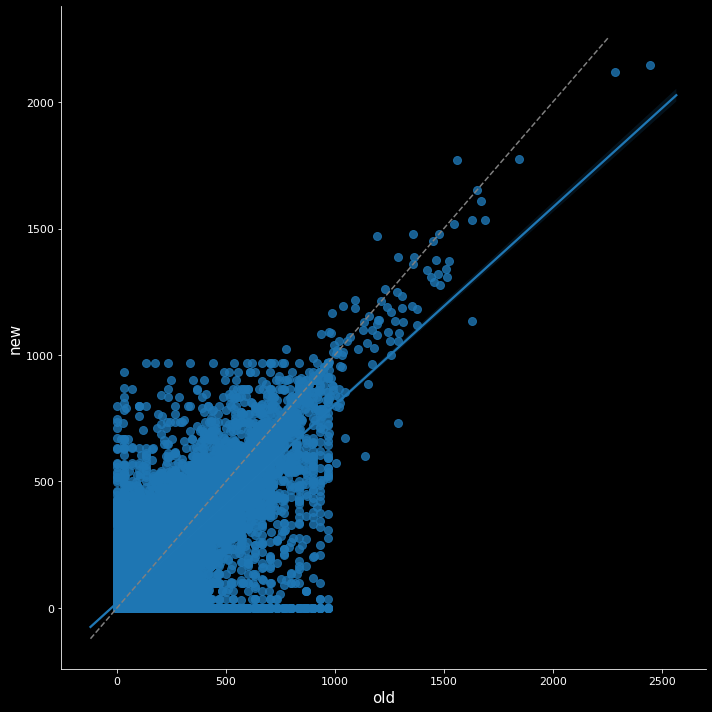

In [87]:
full = Full.loc[('none', 'mean'), :].dropna()
fig, ax = plt.subplots(figsize=(10,10))
_ = sns.regplot(full['old_val'], full['new_val'])
_ = unit_line(ax)
_ = ax.set_xlabel('old')
_ = ax.set_ylabel('new')

it is clear from the previous figures that there are discrepancies between the old and new methods, however the data
lies over the unity line, and these discrepancies can most likely be atributed to the important changes made to the
shuffling test.

Now lets dissect different parts of the dataframe to see if there is any systematic difference. I presume bigger
differences will be seen in the dPCA


# Permutations

['SC' 'fdPCA' 'pdPCA']
['0_1' '0_2' '0_3' '0_4' '1_2' '1_3' '1_4' '2_3' '2_4' '3_4' 'mean']
['1' '2' '3' '4' 'mean']


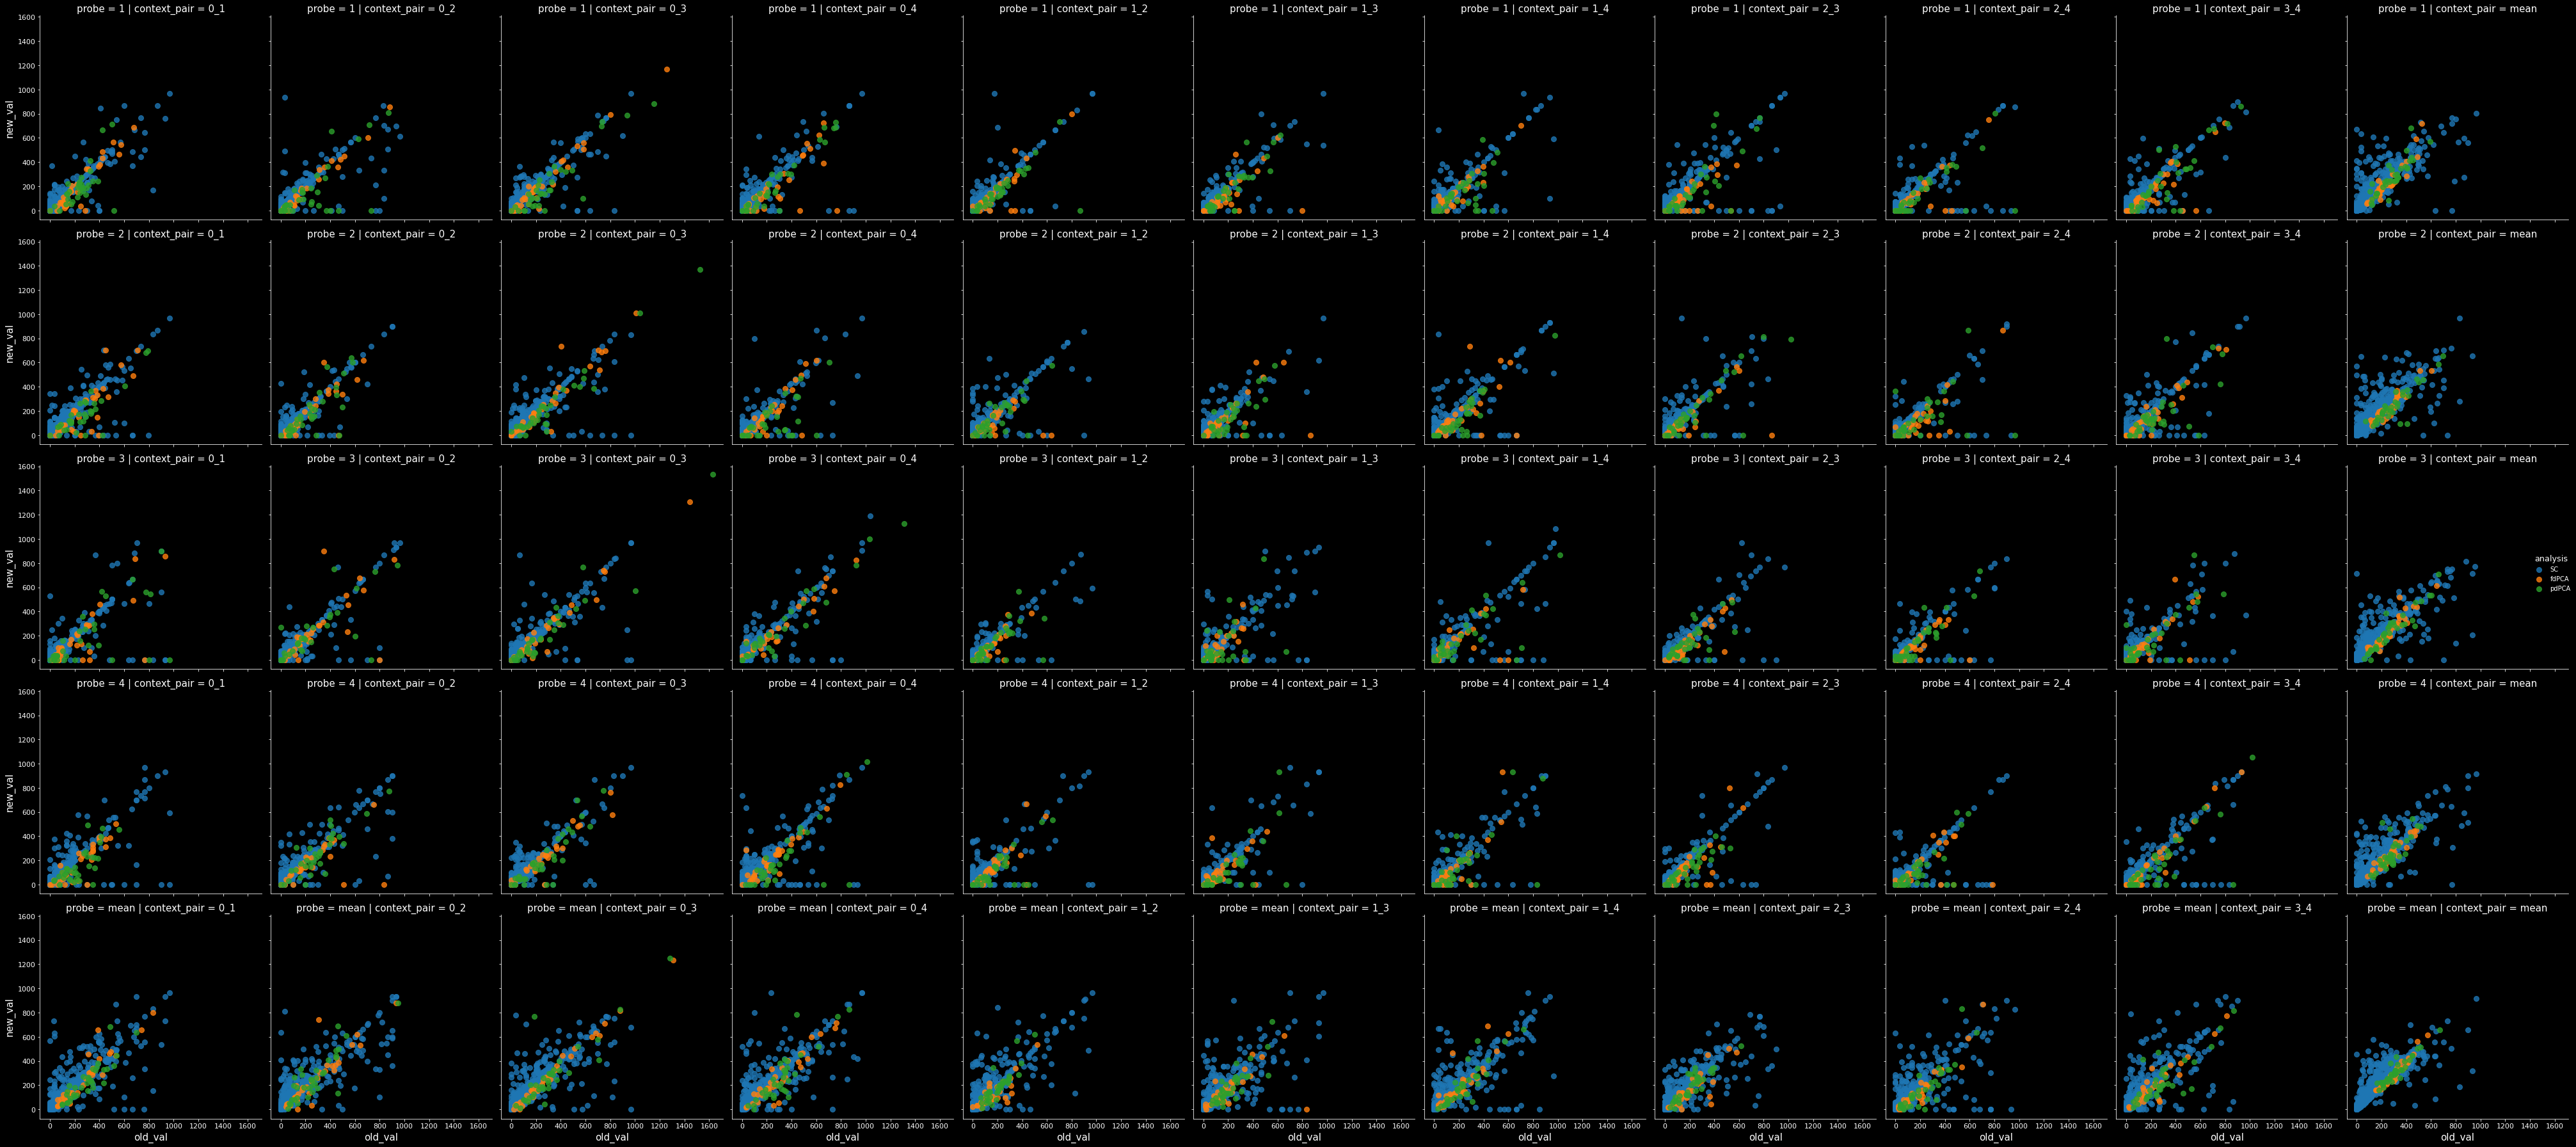

In [89]:
# filter out significance corrections not present in old metrics
full_perm = Full.loc[('none', 'mean', 'permutations'),:].dropna()
toplot = full_perm.reset_index()
print(toplot.analysis.unique())
print(toplot.context_pair.unique())
print(toplot.probe.unique())
g = sns.lmplot(x='old_val', y='new_val', data=toplot,
               hue='analysis', col='context_pair', row='probe', fit_reg=False)


# triplets

['SC' 'fdPCA' 'pdPCA']
['0_1' '0_2' '0_3' '0_4' '1_2' '1_3' '1_4' '2_3' '2_4' '3_4' 'mean']
['1' '2' '3' '4' 'mean']


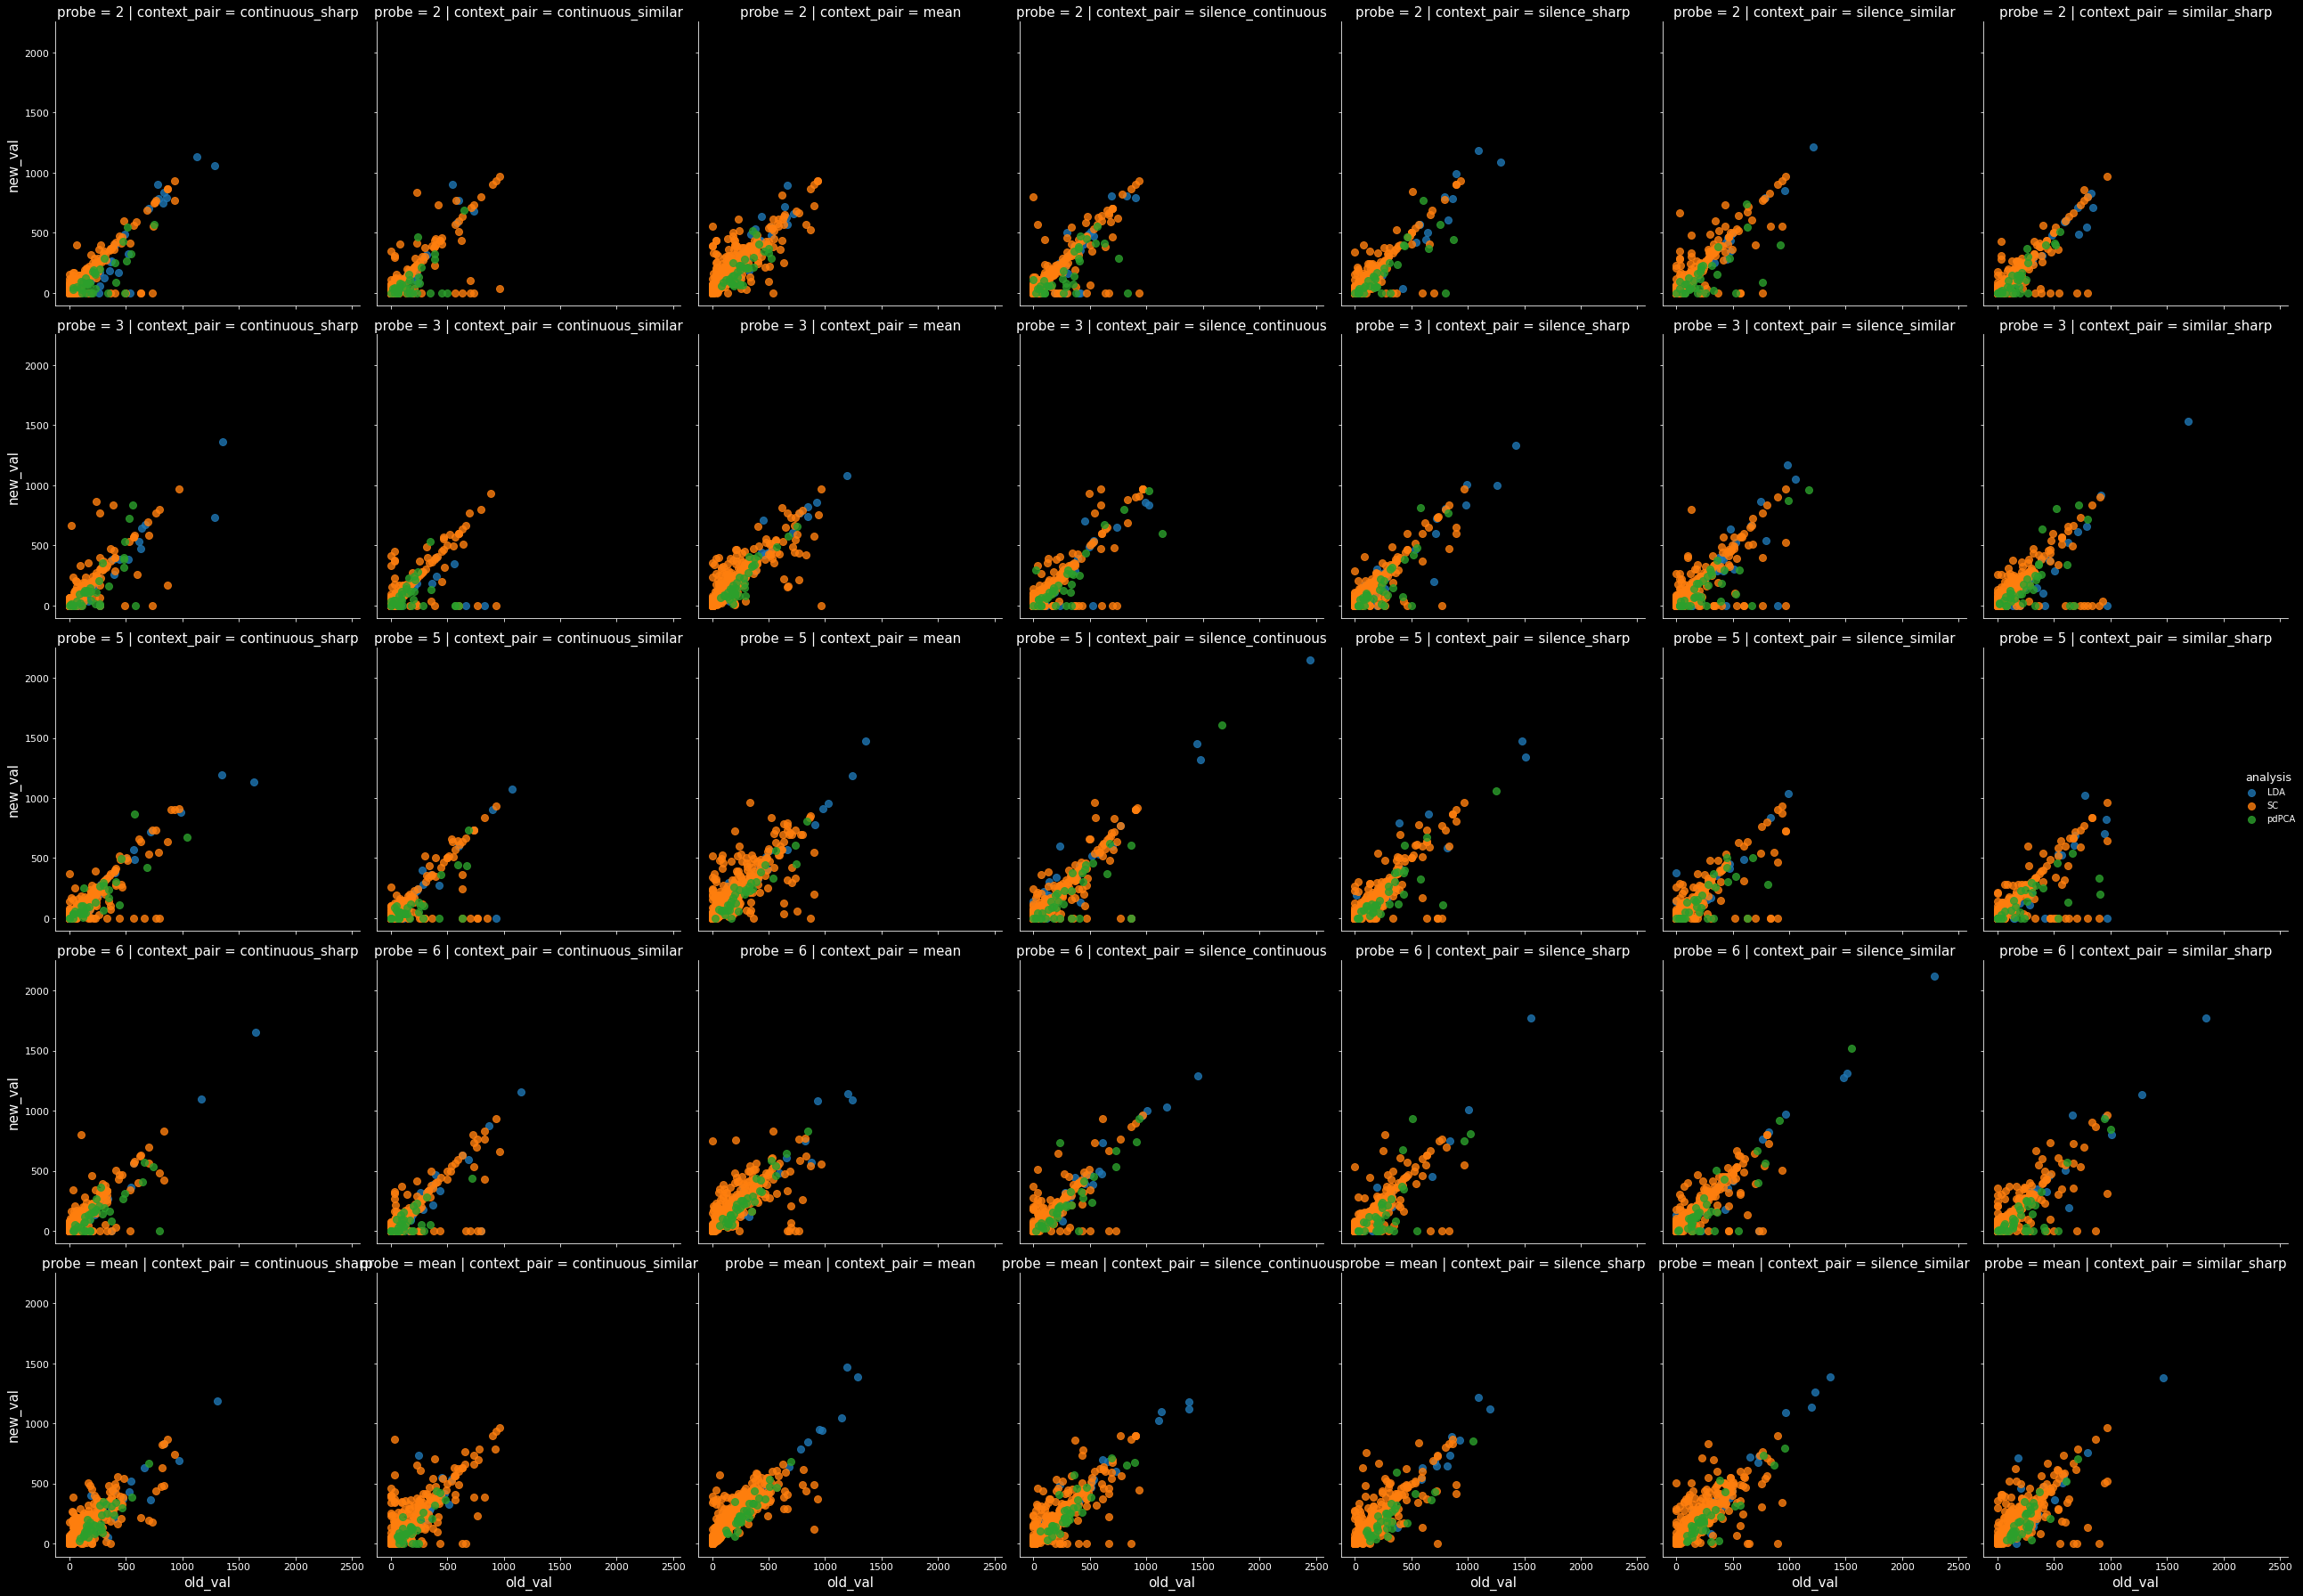

In [90]:
# filter out significance corrections not present in old metrics
full_trip = Full.loc[('none', 'mean', 'triplets'),:].dropna()
print(toplot.analysis.unique())
print(toplot.context_pair.unique())
print(toplot.probe.unique())
toplot = full_trip.reset_index()
# ctx_ord = ['continuous_sharp', 'continuous_similar', 'silence_continuous', 'silence_sharp',
#            'silence_similar', 'similar_sharp', 'mean']
# prb_ord = ['2' '3' '5' '6' 'mean']
g = sns.lmplot(x='old_val', y='new_val', data=toplot,
               hue='analysis', col='context_pair', row='probe', fit_reg=False)


## good results!
overall it seems that the old and new approaches are roughly similar. and given the bad shuffling of the old approach,
it is good to see that the metric values tend to be greater for the new aproach. This is most beneficial for SC and LDA.
dPCA shows a somewhat opposite effect, this is not surpricing, nor inconvenient given the magniture of the difference.
